In [1]:
import json
import numpy as np
import cv2
from glob import glob
from os.path import join as pjoin
from tqdm import tqdm

In [6]:
def resize_label(bboxes, d_height, gt_height, bias=0):
    bboxes_new = []
    scale = gt_height/d_height
    for bbox in bboxes:
        bbox = [int(b * scale + bias) for b in bbox]
        bboxes_new.append(bbox)
    return bboxes_new


def draw_bounding_box(org, corners, color=(0, 255, 0), line=2, show=False):
    board = org.copy()
    for i in range(len(corners)):
        board = cv2.rectangle(board, (corners[i][0], corners[i][1]), (corners[i][2], corners[i][3]), color, line)
    if show:
        cv2.imshow('a', cv2.resize(board, (300, 600)))
        cv2.waitKey(0)
    return board


def load_detect_result_json(reslut_file_root):
    result_files = glob(pjoin(reslut_file_root, '*.json'))
    compos_reform = {}
    print('Loading %d detection results' % len(result_files))
    for reslut_file in tqdm(result_files):
        img_name = reslut_file.split('\\')[-1].split('_')[0]
        compos = json.load(open(reslut_file, 'r'))['compos']
        for compo in compos:
            if img_name not in compos_reform:
                compos_reform[img_name] = {'bboxes': [[compo['column_min'], compo['row_min'], compo['column_max'], compo['row_max']]],
                                           'categories': [compo['class']]}
            else:
                compos_reform[img_name]['bboxes'].append([compo['column_min'], compo['row_min'], compo['column_max'], compo['row_max']])
                compos_reform[img_name]['categories'].append(compo['class'])
    return compos_reform


def load_ground_truth_json(gt_file):
    def get_img_by_id(img_id):
        for image in images:
            if image['id'] == img_id:
                return image['file_name'].split('/')[-1][:-4], (image['height'], image['width'])

    def cvt_bbox(bbox):
        '''
        :param bbox: [x,y,width,height]
        :return: [col_min, row_min, col_max, row_max]
        '''
        bbox = [int(b) for b in bbox]
        return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

    data = json.load(open(gt_file, 'r'))
    images = data['images']
    annots = data['annotations']
    compos = {}
    print('Loading %d ground truth' % len(annots))
    for annot in tqdm(annots):
        img_name, size = get_img_by_id(annot['image_id'])
        if img_name not in compos:
            compos[img_name] = {'bboxes': [cvt_bbox(annot['bbox'])], 'categories': [annot['category_id']], 'size':size}
        else:
            compos[img_name]['bboxes'].append(cvt_bbox(annot['bbox']))
            compos[img_name]['categories'].append(annot['category_id'])
    return compos


def eval(detection, ground_truth, img_root, show=True):
    def match(org, d_bbox, gt_bboxes, matched):
        '''
        :param matched: mark if the ground truth component is matched
        :param d_bbox: [col_min, row_min, col_max, row_max]
        :param gt_bboxes: list of ground truth [[col_min, row_min, col_max, row_max]]
        :return: Boolean: if IOU large enough or detected box is contained by ground truth
        '''
        area_d = (d_bbox[2] - d_bbox[0]) * (d_bbox[3] - d_bbox[1])
        for i, gt_bbox in enumerate(gt_bboxes):
            if matched[i] == 0:
                continue
            area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
            col_min = max(d_bbox[0], gt_bbox[0])
            row_min = max(d_bbox[1], gt_bbox[1])
            col_max = min(d_bbox[2], gt_bbox[2])
            row_max = min(d_bbox[3], gt_bbox[3])
            # if not intersected, area intersection should be 0
            w = max(0, col_max - col_min)
            h = max(0, row_max - row_min)
            area_inter = w * h
            if area_inter == 0:
                continue
            iod = area_inter / area_d
            iou = area_inter / (area_d + area_gt - area_inter)

            # if show:
            #     print("IoDetection: %.3f, IoU: %.3f" % (iod, iou))
            #     broad = draw_bounding_box(org, [d_bbox], color=(0, 0, 255))
            #     draw_bounding_box(broad, [gt_bbox], color=(0, 255, 0), show=True)

            if iou >= 0.5 or iod == 1:
                matched[i] = 0
                return True
        return False

    pres = []
    recalls = []
    amount = len(detection)
    for i, image_id in enumerate(detection):
        TP, FP, FN = 0, 0, 0
        img = cv2.imread(pjoin(img_root, image_id + '.jpg'))
        d_compos = detection[image_id]
        gt_compos = ground_truth[image_id]
        d_compos['bboxes'] = resize_label(d_compos['bboxes'], 800, gt_compos['size'][0])
        matched = np.ones(len(gt_compos['bboxes']), dtype=int)
        for d_bbox in d_compos['bboxes']:
            if match(img, d_bbox, gt_compos['bboxes'], matched):
                TP += 1
            else:
                FP += 1
        FN += sum(matched)

        precesion = TP / (TP+FP)
        recall = TP / (TP+FN)

        pres.append(precesion)
        recalls.append(recall)
        if show:
            print("Number of gt boxes: %d, Number of detected boxes: %d" % (
            len(gt_compos['bboxes']), len(d_compos['bboxes'])))
            print('[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f' % (i, amount, TP, FP, FN, precesion, recall))

            broad = draw_bounding_box(img,  d_compos['bboxes'], color=(0, 0, 255), line=3)
            draw_bounding_box(broad, gt_compos['bboxes'], color=(0, 255, 0), show=True, line=2)

        if i % 200 == 0:
            print('[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f' % (i, amount, TP, FP, FN, precesion, recall))

    return pres, recalls

In [7]:
detect = load_detect_result_json('E:\\Mulong\\Result\\rico2\\ip')
gt = load_ground_truth_json('E:/Mulong/Datasets/rico/instances_val_notext.json')
pres, recalls = eval(detect, gt, 'E:\\Mulong\\Datasets\\rico\\combined', show=False)

 17%|█▋        | 748/4318 [00:00<00:00, 3866.72it/s]

Loading 4318 detection results


  8%|▊         | 7208/90722 [00:00<00:01, 71540.23it/s]

Loading 90722 ground truth


100%|██████████| 90722/90722 [00:12<00:00, 7451.24it/s] 


[0/4318] TP:2, FP:12, FN:4, Precesion:0.143, Recall:0.333
[200/4318] TP:9, FP:0, FN:0, Precesion:1.000, Recall:1.000
[400/4318] TP:4, FP:25, FN:6, Precesion:0.138, Recall:0.400
[600/4318] TP:2, FP:4, FN:12, Precesion:0.333, Recall:0.143
[800/4318] TP:11, FP:10, FN:2, Precesion:0.524, Recall:0.846
[1000/4318] TP:1, FP:5, FN:2, Precesion:0.167, Recall:0.333
[1200/4318] TP:12, FP:2, FN:2, Precesion:0.857, Recall:0.857
[1400/4318] TP:8, FP:3, FN:14, Precesion:0.727, Recall:0.364
[1600/4318] TP:12, FP:3, FN:3, Precesion:0.800, Recall:0.800
[1800/4318] TP:24, FP:7, FN:12, Precesion:0.774, Recall:0.667
[2000/4318] TP:5, FP:7, FN:8, Precesion:0.417, Recall:0.385
[2200/4318] TP:2, FP:20, FN:0, Precesion:0.091, Recall:1.000
[2400/4318] TP:5, FP:24, FN:0, Precesion:0.172, Recall:1.000
[2600/4318] TP:6, FP:32, FN:9, Precesion:0.158, Recall:0.400
[2800/4318] TP:5, FP:6, FN:10, Precesion:0.455, Recall:0.333
[3000/4318] TP:17, FP:11, FN:19, Precesion:0.607, Recall:0.472
[3200/4318] TP:22, FP:6, FN:15

D:\Anaconda\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


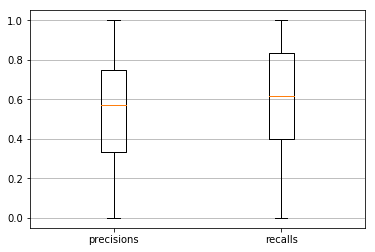

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
ax.boxplot([pres, recalls])
ax.set_xticklabels(['precisions', 'recalls'])
plt.grid(axis='y')
fig.show()